In [58]:
import yfinance as yf
import pandas as pd
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from concurrent.futures import ProcessPoolExecutor
from datetime import datetime

In [29]:
def download_yfinance_data(tickers, start_date, end_date):
    """
    Download historical stock data from Yahoo Finance for the given tickers and date range.
    Combine all data into a single DataFrame with a fixed daily index.
    """
    date_dataframe = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='D'), columns=['Date'])

    for ticker in tqdm(tickers):
        try:
            check = yf.Ticker(ticker)
            if check.info['quoteType'] == 'CRYPTOCURRENCY':
                data_ticker = yf.download(ticker, start=start_date, end=end_date, multi_level_index=False)
                if not data_ticker.empty:
                     # Determine which column to use
                    close_column = 'Adj Close' if 'Adj Close' in data_ticker.columns else 'Close'
                    data_extract = data_ticker[[close_column]].rename(columns={close_column: ticker})
                    date_dataframe = date_dataframe.merge(data_extract, left_on='Date', right_index=True, how='left')
        except Exception as e:
            print(f"Error for {ticker}: {e}")

    return date_dataframe

In [30]:
df_all_crypto = pd.read_csv('Data/crypto_list_20250325.csv')
df_all_crypto['symbol'] = df_all_crypto['crypto'] + '-USD'



In [31]:
# Analysis on snp500 only
start_date = "2020-01-01"
end_date = "2025-01-31"
tickers = df_all_crypto['symbol'].to_list()  # Example tickers

df = download_yfinance_data(tickers, start_date, end_date)

if df is not None:
    df.to_csv("Data/yfinance_crypto_data_202001_202501.csv")
    print("Data successfully downloaded and saved to yfinance_data.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Error for IP-USD: 'NoneType' object has no attribute 'update'


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Data successfully downloaded and saved to yfinance_data.csv


In [33]:
df = df.set_index('Date')

In [34]:

df_clean = df.dropna(axis=1, thresh=int(len(df.index)/2), inplace=False)

c = df_clean.corr().abs()
# Remove self-correlation and keep only one side of the matrix
c = c.where(~np.tril(np.ones(c.shape), k=0).astype(bool))
s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False).reset_index()
so.columns = ['ticker_1', 'ticker_2', 'correlation']
so.to_csv('Data/crypto_correlations_202001_202501.zip')

In [35]:
so

,ticker_1,ticker_2,correlation
0,PAXG-USD,XAUt-USD,0.998048
1,FORM-USD,APT-USD,0.975359
2,SAND-USD,GALA-USD,0.968089
3,ALGO-USD,DOT-USD,0.945923
4,CAKE-USD,VET-USD,0.942752
...,...,...,...
6079,HNT-USD,NEO-USD,NaN
6080,HNT-USD,AXS-USD,NaN
6081,NEO-USD,NEO-USD,NaN
6082,NEO-USD,AXS-USD,NaN


In [36]:
so[so['correlation']<1]

,ticker_1,ticker_2,correlation
0,PAXG-USD,XAUt-USD,0.998048
1,FORM-USD,APT-USD,0.975359
2,SAND-USD,GALA-USD,0.968089
3,ALGO-USD,DOT-USD,0.945923
4,CAKE-USD,VET-USD,0.942752
...,...,...,...
2998,DAI-USD,BGB-USD,0.000757
2999,SAND-USD,TIA-USD,0.000716
3000,TIA-USD,XRP-USD,0.000680
3001,JUP-USD,UNI-USD,0.000171


In [37]:
## check for cointegration
def check_stationarity(series):
    """Returns the p-value from the Augmented Dickey-Fuller (ADF) test."""
    return adfuller(series)[1]  # ADF test p-value

def calculate_cointegration(corr_df, timeseries_df):
    """
    Takes in:
    - corr_df: DataFrame with columns ['ticker1', 'ticker2', 'correl']
    - timeseries_df: DataFrame where each column is a ticker's time series.

    Adds three new columns:
    - 'p1_stationary': ADF p-value for ticker1
    - 'p2_stationary': ADF p-value for ticker2
    - 'p_cointegration': Cointegration test p-value
    """

    results = []  # Store results for efficient DataFrame construction

    for index, row in corr_df.iterrows():
        t1, t2 = row["ticker_1"], row["ticker_2"]

        # Get time series data
        series1 = timeseries_df[t1].dropna()
        series2 = timeseries_df[t2].dropna()

        # Ensure both series have the same length
        min_len = min(len(series1), len(series2))
        series1, series2 = series1.iloc[-min_len:], series2.iloc[-min_len:]

        # Check stationarity (ADF test)
        p1 = check_stationarity(series1)
        p2 = check_stationarity(series2)

        # Check cointegration only if both series are non-stationary (p > 0.05)
        if p1 > 0.05 and p2 > 0.05:
            p_cointegration1 = coint(series1, series2, trend='c')[1]  # Engle-Granger test p-value
            p_cointegration2 = coint(series2, series1, trend='c')[1]
        else:
            p_cointegration1 = np.nan  # Not applicable
            p_cointegration2 = np.nan

        results.append((t1, t2, p1, p2, p_cointegration1, p_cointegration2))

    # Convert results into DataFrame and merge with original correlation DataFrame
    results_df = pd.DataFrame(results, columns=["ticker_1", "ticker_2", "p1_stationary", "p2_stationary", "p_cointegration1", "p_cointegration2"])
    return corr_df.merge(results_df, on=["ticker_1", "ticker_2"])

corr_df = calculate_cointegration(so, df)
corr_df.to_csv('Data/Cryptocointegration_results_temp2.csv')
corr_df['p_coint_avg'] = corr_df[['p_cointegration1', 'p_cointegration2']].mean(axis=1, skipna=True)
corr_df['p_coint_min'] = corr_df[['p_cointegration1', 'p_cointegration2']].min(axis=1, skipna=True)
corr_df['p_coint_max'] = corr_df[['p_cointegration1', 'p_cointegration2']].max(axis=1, skipna=True)
corr_df.to_csv('Data/Cryptocointegration_results_202001_202501.csv')

C:\Users\joeytian\AppData\Local\Temp\ipykernel_8416\3992867426.py:37: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  p_cointegration1 = coint(series1, series2, trend='c')[1]  # Engle-Granger test p-value
C:\Users\joeytian\AppData\Local\Temp\ipykernel_8416\3992867426.py:38: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  p_cointegration2 = coint(series2, series1, trend='c')[1]
C:\Users\joeytian\AppData\Local\Temp\ipykernel_8416\3992867426.py:37: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  p_cointegration1 = coint(series1, series2, trend='c')[1]  # Engle-Granger test p-value
C:\Users\joeytian\AppData\Local\Temp\ipykernel_8416\3992867426.py:38: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  p_cointegration2 = coint(series2,

In [38]:
promising_pairs1 = corr_df[(corr_df['p_coint_max']>0) &
        (corr_df['p_coint_max']<0.01) &
        (corr_df['p1_stationary']>=0.05) &
        (corr_df['p2_stationary']>=0.05) &
        (~corr_df['correlation'].isna())
        ].sort_values(by='p_coint_max', ascending=True)

In [39]:
promising_pairs1['regress1on2'] = promising_pairs1['p_cointegration1'] < promising_pairs1['p_cointegration2']

In [40]:
promising_pairs1.head()

,ticker_1,ticker_2,correlation,p1_stationary,p2_stationary,p_cointegration1,p_cointegration2,p_coint_avg,p_coint_min,p_coint_max,regress1on2
2,SAND-USD,GALA-USD,0.968089,0.174650,0.078377,8.032040e-11,4.336715e-13,4.037704e-11,4.336715e-13,8.032040e-11,False
31,NEO-USD,THETA-USD,0.904653,0.069346,0.149278,5.511595e-11,2.933546e-10,1.742353e-10,5.511595e-11,2.933546e-10,True
12,NEO-USD,FIL-USD,0.927523,0.069346,0.129611,2.377859e-09,7.578423e-09,4.978141e-09,2.377859e-09,7.578423e-09,True
61,NEO-USD,TON-USD,0.886029,0.110804,0.203382,1.403805e-08,1.991493e-08,1.697649e-08,1.403805e-08,1.991493e-08,True
30,CAKE-USD,THETA-USD,0.905409,0.244063,0.169921,8.309885e-07,4.822827e-07,6.566356e-07,4.822827e-07,8.309885e-07,False
...,...,...,...,...,...,...,...,...,...,...,...
118,CAKE-USD,ADA-USD,0.859939,0.244063,0.225475,8.861149e-03,4.279718e-03,6.570434e-03,4.279718e-03,8.861149e-03,False
192,HNT-USD,ATOM-USD,0.827863,0.369034,0.166645,8.908664e-03,2.590069e-03,5.749367e-03,2.590069e-03,8.908664e-03,False
413,DEXE-USD,BCH-USD,0.758306,0.185322,0.216621,1.525207e-03,8.910547e-03,5.217877e-03,1.525207e-03,8.910547e-03,True
172,GALA-USD,AVAX-USD,0.834928,0.078377,0.134376,3.221667e-03,9.152430e-03,6.187048e-03,3.221667e-03,9.152430e-03,True


In [41]:
def plot_dual_axis(df, ticker1, ticker2):
    """
    Plots two time series on separate y-axes.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time series.
        ticker1 (str): First ticker (plotted on left y-axis).
        ticker2 (str): Second ticker (plotted on right y-axis).
    """
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # First time series (ticker1)
    ax1.plot(df.index, df[ticker1], marker=".", markersize=1, color="b", label=ticker1)
    ax1.set_xlabel("Date")
    ax1.set_ylabel(f"{ticker1} Value", color="b")
    ax1.tick_params(axis="y", labelcolor="b")
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Second time series (ticker2) on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(df.index, df[ticker2], marker=".", markersize=1, color="r", label=ticker2)
    ax2.set_ylabel(f"{ticker2} Value", color="r")
    ax2.tick_params(axis="y", labelcolor="r")

    # Legend
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
    plt.title(f"{ticker1} vs {ticker2} Time Series")

    # Show plot
    plt.show()

In [42]:
def plot_same_axis(df, ticker1, ticker2, factor1=1, factor2=1):
    """
    Plots two time series on the same y-axis.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time series.
        ticker1 (str): First ticker to plot.
        ticker2 (str): Second ticker to plot.
        factor1 (float, optional): Multiplicative factor for the first series. Default is 1.
        factor2 (float, optional): Multiplicative factor for the second series. Default is 1.
    """
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot both series on the same axis
    ax.plot(df.index, df[ticker1] * factor1, marker=".", markersize=1, color="b", label=ticker1)
    ax.plot(df.index, df[ticker2] * factor2, marker=".", markersize=1, color="r", label=ticker2)

    # Labels and title
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    ax.set_title(f"{ticker1} vs {ticker2} Time Series")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)

    # Show plot
    plt.show()

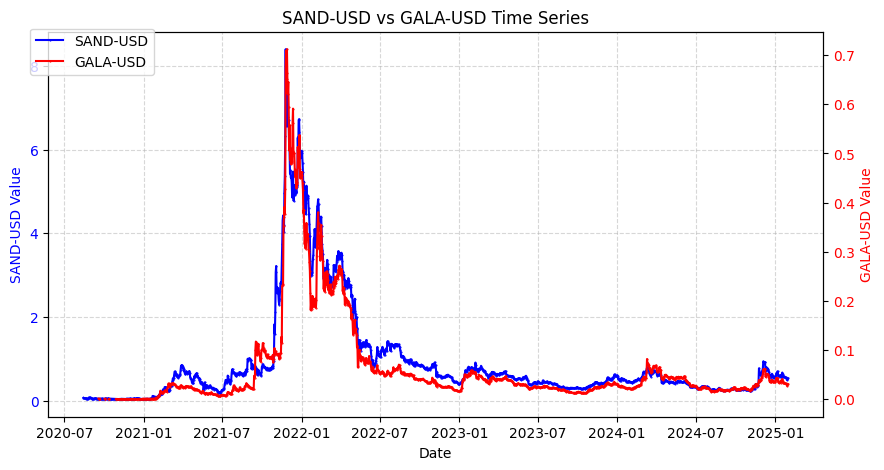

In [44]:
plot_dual_axis(df, "SAND-USD", "GALA-USD")  # Pass any two tickers


In [45]:
def get_cointegration_factor(ticker_1_series, ticker_2_series, f_1on2):
    """
    Calculates the cointegration factor (β) using OLS regression with an intercept.

    Returns:
        float: Cointegration factor (β), or NaN if computation fails.
    """
    try:
        series1 = ticker_1_series.dropna()
        series2 = ticker_2_series.dropna()

        # Ensure both series have the same length
        min_len = min(len(series1), len(series2))
        if min_len < 20:
            return np.nan  # Not enough data points

        series1, series2 = series1.iloc[-min_len:], series2.iloc[-min_len:]
        if (f_1on2):
            # OLS Regression: ticker_1 ~ ticker_2 (without intercept)
            model = sm.OLS(series1, series2, hasconst=True).fit()
        else:
            model = sm.OLS(series2, series1, hasconst=True).fit()
        return model.params[0]  # Extract β coefficient (slope)

    except Exception as e:
        print("Exception occurred ",e )
        return np.nan  # Return NaN if an error occurs

In [46]:
promising_pairs1['coint_factor'] = promising_pairs1.apply(lambda row: get_cointegration_factor(df[row['ticker_1']], df[row['ticker_2']], row['regress1on2']), axis=1)


Exception occurred  The indices for endog and exog are not aligned
Exception occurred  The indices for endog and exog are not aligned
Exception occurred  The indices for endog and exog are not aligned
Exception occurred  The indices for endog and exog are not aligned
Exception occurred  The indices for endog and exog are not aligned
Exception occurred  The indices for endog and exog are not aligned


C:\Users\joeytian\AppData\Local\Temp\ipykernel_8416\1466072515.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[0]  # Extract β coefficient (slope)


In [47]:
promising_pairs1.to_csv('Data/promising_crypto_pairs.csv', index=False)

In [49]:
promising_pairs1

,ticker_1,ticker_2,correlation,p1_stationary,p2_stationary,p_cointegration1,p_cointegration2,p_coint_avg,p_coint_min,p_coint_max,regress1on2,coint_factor
2,SAND-USD,GALA-USD,0.968089,0.174650,0.078377,8.032040e-11,4.336715e-13,4.037704e-11,4.336715e-13,8.032040e-11,False,NaN
31,NEO-USD,THETA-USD,0.904653,0.069346,0.149278,5.511595e-11,2.933546e-10,1.742353e-10,5.511595e-11,2.933546e-10,True,6.937421
12,NEO-USD,FIL-USD,0.927523,0.069346,0.129611,2.377859e-09,7.578423e-09,4.978141e-09,2.377859e-09,7.578423e-09,True,0.636338
61,NEO-USD,TON-USD,0.886029,0.110804,0.203382,1.403805e-08,1.991493e-08,1.697649e-08,1.403805e-08,1.991493e-08,True,5.548228
30,CAKE-USD,THETA-USD,0.905409,0.244063,0.169921,8.309885e-07,4.822827e-07,6.566356e-07,4.822827e-07,8.309885e-07,False,0.380102
...,...,...,...,...,...,...,...,...,...,...,...,...
118,CAKE-USD,ADA-USD,0.859939,0.244063,0.225475,8.861149e-03,4.279718e-03,6.570434e-03,4.279718e-03,8.861149e-03,False,0.090797
192,HNT-USD,ATOM-USD,0.827863,0.369034,0.166645,8.908664e-03,2.590069e-03,5.749367e-03,2.590069e-03,8.908664e-03,False,1.101563
413,DEXE-USD,BCH-USD,0.758306,0.185322,0.216621,1.525207e-03,8.910547e-03,5.217877e-03,1.525207e-03,8.910547e-03,True,0.020320
172,GALA-USD,AVAX-USD,0.834928,0.078377,0.134376,3.221667e-03,9.152430e-03,6.187048e-03,3.221667e-03,9.152430e-03,True,NaN


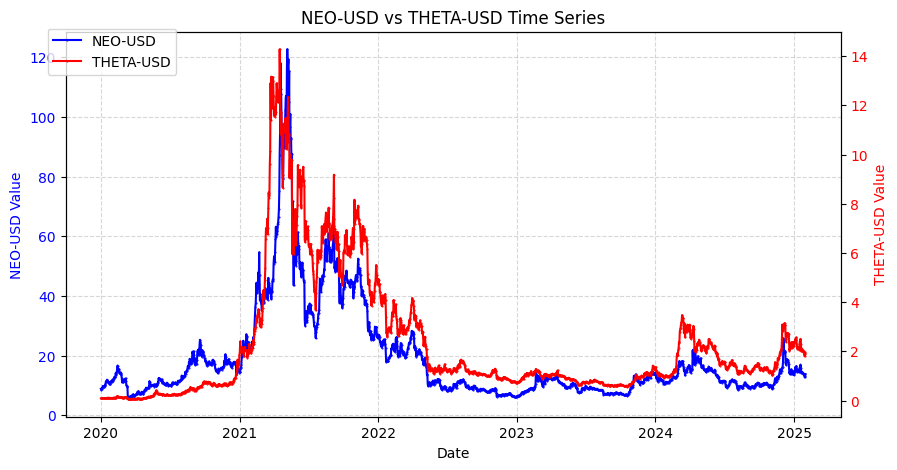

In [50]:
plot_dual_axis(df, "NEO-USD", "THETA-USD")

In [51]:
get_cointegration_factor(df['NEO-USD'], df['THETA-USD'],True)

C:\Users\joeytian\AppData\Local\Temp\ipykernel_8416\1466072515.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[0]  # Extract β coefficient (slope)


np.float64(6.937420759185082)

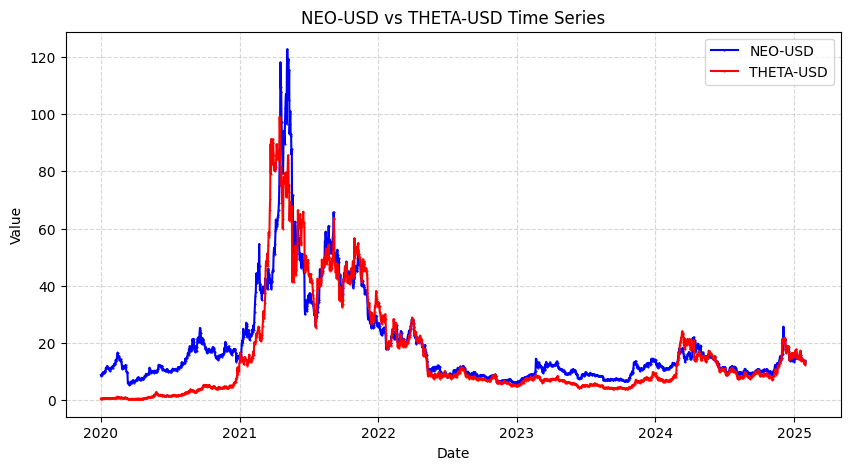

In [54]:
plot_same_axis(df, "NEO-USD", "THETA-USD",1,6.937420759185082)

In [55]:
def calculate_residuals(series_y, series_x, beta):
    residuals = series_y / (beta * series_x) - 1
    mean = residuals.mean()
    std = residuals.std()
    residuals_std = (residuals - mean) / std
    return residuals, residuals_std, mean, std

In [56]:
promising_pairs1[['coint_resid_mean', 'coint_resid_std']] = promising_pairs1.apply(
    lambda row: pd.Series(
        calculate_residuals(df[row['ticker_1']], df[row['ticker_2']], row['coint_factor'])[2:4]
        if row['regress1on2']
        else calculate_residuals(df[row['ticker_2']], df[row['ticker_1']], row['coint_factor'])[2:4]
    ),
    axis=1
)


C:\Users\joeytian\anaconda3\envs\algo\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [57]:
promising_pairs1['current']

KeyError: 'current'

In [146]:
def get_latest_resid(symbol_y, symbol_x, beta, mean, std):
    latest_y = yf.Ticker(symbol_y).fast_info['lastPrice']
    latest_x = yf.Ticker(symbol_x).fast_info['lastPrice']
    latest_resid = latest_y / (beta * latest_x) - 1
    return (latest_resid - mean)/std

promising_pairs1['current_signal'] = promising_pairs1.apply(lambda row: get_latest_resid(row['ticker_1'], row['ticker_2'], row['coint_factor'], row['coint_resid_mean'], row['coint_resid_std']) if row['regress1on2'] else get_latest_resid(row['ticker_2'], row['ticker_1'], row['coint_factor'], row['coint_resid_mean'], row['coint_resid_std']), axis=1)


In [188]:
promising_pairs1[promising_pairs1['current_signal'].abs() > 2.5]

,ticker_1,ticker_2,correlation,p1_stationary,p2_stationary,p_cointegration1,p_cointegration2,p_coint_avg,p_coint_min,p_coint_max,regress1on2,coint_factor,coint_resid_mean,coint_resid_std,current_signal
204,WAB,AVGO,0.969750,0.997958,0.994512,0.000016,0.000011,0.000013,0.000011,0.000016,False,1.195107,-0.454328,0.158727,2.584848
183,RL,JPM,0.971434,0.996973,0.996910,0.000169,0.000380,0.000275,0.000169,0.000380,True,1.174558,-0.296052,0.058146,3.337362
159,DECK,AVGO,0.972275,0.998633,0.994512,0.000635,0.000524,0.000580,0.000524,0.000635,False,1.040765,-0.134442,0.140598,3.985575
293,PM,MO,0.965681,0.970588,0.800445,0.000944,0.000526,0.000735,0.000526,0.000944,False,2.256283,-0.801514,0.011398,-3.667006
3300,GRMN,DVA,0.922158,0.988186,0.846206,0.001632,0.000667,0.001149,0.000667,0.001632,False,1.110366,-0.166796,0.092527,-2.799982
1384,PM,PEG,0.944544,0.970588,0.894706,0.002486,0.001465,0.001976,0.001465,0.002486,False,1.433547,-0.510248,0.035813,-3.160951
13304,HRL,ES,0.846042,0.636613,0.277631,0.003314,0.000949,0.002132,0.000949,0.003314,False,0.561308,2.188815,0.248100,2.631311
556,GD,ABBV,0.959132,0.801838,0.777157,0.003434,0.003356,0.003395,0.003356,0.003434,False,1.635387,-0.632897,0.032320,4.319894
15238,STZ,HST,0.833637,0.222519,0.175241,0.003965,0.003070,0.003518,0.003070,0.003965,False,14.375949,-0.995214,0.000492,3.109545
1572,URI,AVGO,0.941775,0.941321,0.994512,0.002506,0.005074,0.003790,0.002506,0.005074,True,0.199245,27.634800,5.204254,-2.570931


<Axes: xlabel='Date'>

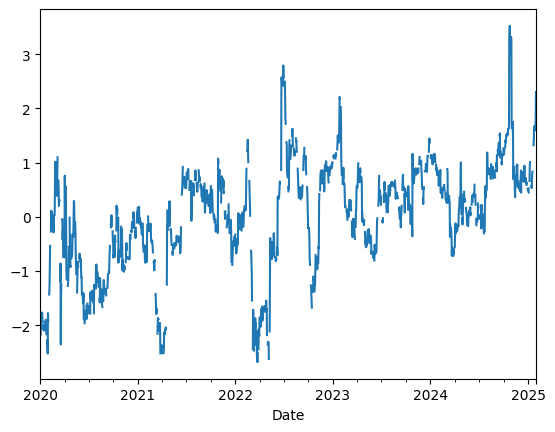

In [187]:
calculate_residuals(df['MO'], df['PM'],2.2562831761575657)[1].plot()

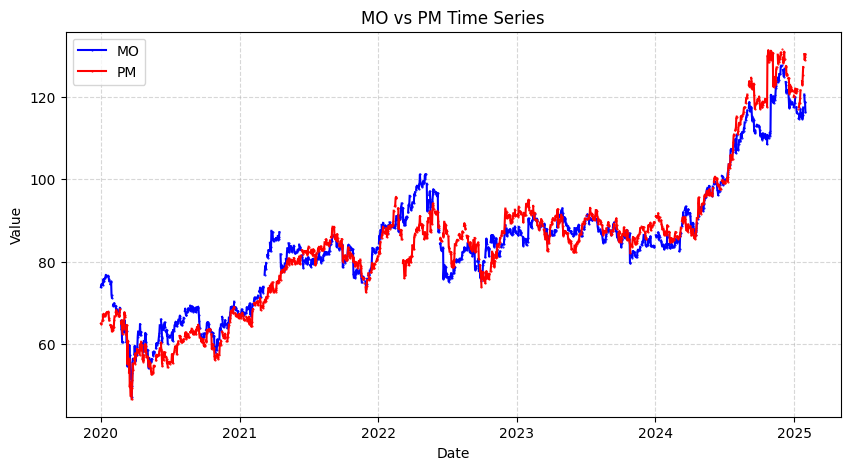

In [190]:
plot_same_axis(df, "MO", "PM",2.2562831761575657,1)

In [191]:
ticker_1, factor_1 = 'MO',2.2562831761575657
ticker_2, factor_2 = 'PM',1


ticker_1_latest = yf.Ticker(ticker_1).fast_info['lastPrice']
ticker_2_latest = yf.Ticker(ticker_2).fast_info['lastPrice']
midpoint = (ticker_1_latest*factor_1 + ticker_2_latest*factor_2)/2

print(f"ticker {ticker_1} latest price is {ticker_1_latest}")
print(f"ticker {ticker_2} latest price is {ticker_2_latest}")
print(f"Average middle is {midpoint}, which is {midpoint/factor_1} for {ticker_1} and {midpoint/factor_2} for {ticker_2}")



ticker MO latest price is 55.25
ticker PM latest price is 156.27999877929688
Average middle is 140.4698221310012, which is 62.257177474602415 for MO and 140.4698221310012 for PM


In [186]:
df['AVGO']

Date
2020-01-01           NaN
2020-01-02     27.986187
2020-01-03     27.274353
2020-01-04           NaN
2020-01-05           NaN
                 ...    
2025-01-27    202.130005
2025-01-28    207.360001
2025-01-29    206.350006
2025-01-30    215.660004
2025-01-31           NaN
Name: AVGO, Length: 1858, dtype: float64

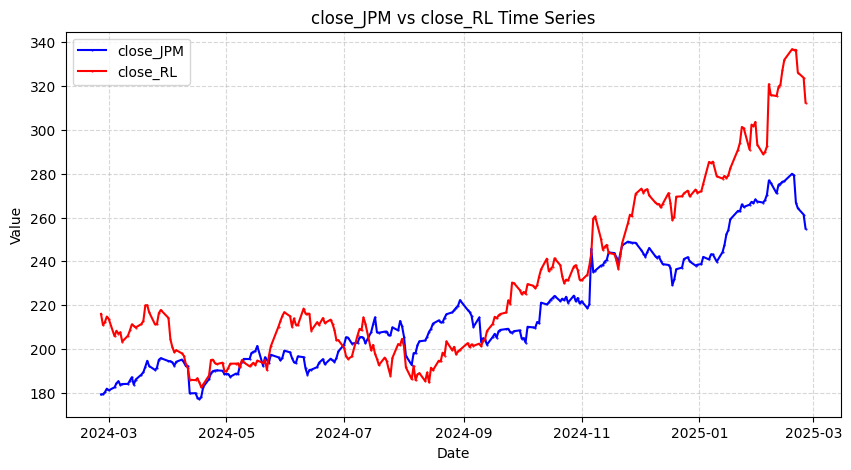

In [36]:
#download live latest data
ticker_1 = 'JPM'
ticker_2 = 'RL'
ticker_1_live = yf.Ticker(ticker_1).history(interval = '1d', period='1y')[['Close']].rename(columns={'Close':f'close_{ticker_1}'})
ticker_2_live = yf.Ticker(ticker_2).history(interval = '1d', period='1y')[['Close']].rename(columns={'Close':f'close_{ticker_2}'})
ticker = ticker_1_live.merge(ticker_2_live, left_index=True, right_index=True, how='outer')

plot_same_axis(ticker, f'close_{ticker_1}', f'close_{ticker_2}',1,1.174558)

In [ ]:
plot_same_axis(df, "MO", "PM",2.2562831761575657,1)

In [42]:
yf.Ticker('S68.SI').news

[{'id': '91635771-8c71-3bed-98c4-58ee61f58a41',
  'content': {'id': '91635771-8c71-3bed-98c4-58ee61f58a41',
   'contentType': 'STORY',
   'title': 'Singapore Exchange First Half 2025 Earnings: EPS: S$0.32 (vs S$0.26 in 1H 2024)',
   'description': '',
   'summary': 'Singapore Exchange ( SGX:S68 ) First Half 2025 Results Key Financial Results Revenue: S$682.2m (up 15% from 1H 2024...',
   'pubDate': '2025-02-07T22:28:46Z',
   'displayTime': '2025-02-07T22:28:46Z',
   'isHosted': True,
   'bypassModal': False,
   'previewUrl': None,
   'thumbnail': {'originalUrl': 'https://media.zenfs.com/en/simply_wall_st__316/78a8c60a6283aea0450523395306d38c',
    'originalWidth': 945,
    'originalHeight': 636,
    'caption': '',
    'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/5Vpve0Pc2F3m_L3fs2p_dQ--~B/aD02MzY7dz05NDU7YXBwaWQ9eXRhY2h5b24-/https://media.zenfs.com/en/simply_wall_st__316/78a8c60a6283aea0450523395306d38c',
      'width': 945,
      'height': 636,
      'tag': 'original'},
